In [1]:
from ROOT import TFile
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize , stats

Welcome to JupyROOT 6.22/06


In [2]:
path="/home/aa/EPPT/run/"
case = "case1"

In [12]:
if (case == 'case1') or (case == 'case1_PbBefore') or (case == 'case1_PbAfter') :
    P_TRUE = 100
    B_TRUE = 0.5
elif (case == 'case2') or (case == 'case2_PbBefore') or (case == 'case2_PbAfter') :
    P_TRUE = 100
    B_TRUE = 0.25
elif (case == 'case3') or (case == 'case3_PbBefore') or (case == 'case3_PbAfter') :
    P_TRUE = 100
    B_TRUE = 1
elif (case == 'case4') or (case == 'case4_PbBefore') or (case == 'case4_PbAfter') :
    P_TRUE = 50
    B_TRUE = 0.5
elif (case == 'case5') or (case == 'case5_PbBefore') or (case == 'case5_PbAfter') :
    P_TRUE = 200
    B_TRUE = 0.5

#Load file and tree 
load_file = TFile(path+"B5_"+case+".root", "READ")
tree = load_file.Get('B5')

In [45]:
ECEnergy = []
for entry in range(0, tree.GetEntries()):
    tree.GetEntry(entry)
    if (np.array( getattr(tree, 'ECEnergy')) /1000 > 0):
        ECEnergy.append( np.array( getattr(tree, 'ECEnergy')) /1000 )
        
HCEnergy = []
for entry in range(0, tree.GetEntries()):
    tree.GetEntry(entry)
    if (np.array( getattr(tree, 'HCEnergy')) /1000 > 0):
        HCEnergy.append( np.array( getattr(tree, 'HCEnergy')) /1000 )
    

(array([  0., 100., 200., 300., 400., 500.]),
 <a list of 6 Text major ticklabel objects>)

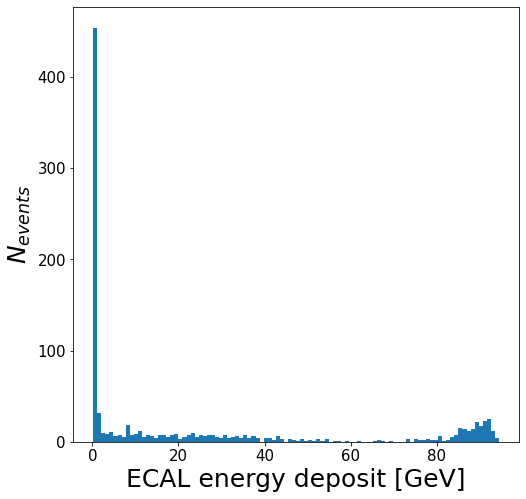

In [46]:
fig = plt.figure(figsize=(8,8))

y, x, _ = plt.hist(ECEnergy,bins=100,range=(min(ECEnergy),max(ECEnergy)),density=False)


plt.xlabel('ECAL energy deposit [GeV]',fontsize=25)
plt.ylabel('$N_{events}$',fontsize=25)
plt.xticks(fontsize=15) 
plt.yticks(fontsize=15)


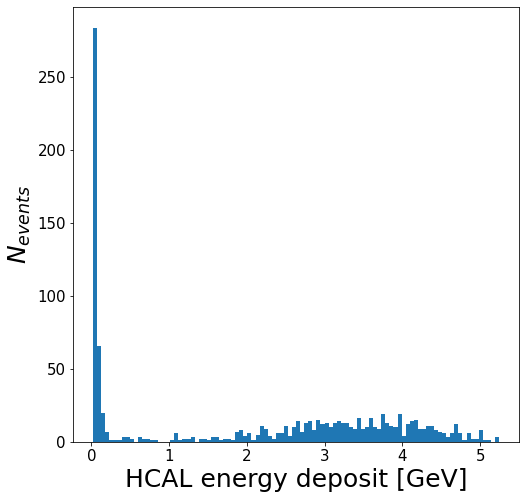

In [44]:
fig = plt.figure(figsize=(8,8))

y, x, _ = plt.hist(HCEnergy,bins=100,range=(min(HCEnergy),max(HCEnergy)),density=False)


plt.xlabel('HCAL energy deposit [GeV]',fontsize=25)
plt.ylabel('$N_{events}$',fontsize=25)
plt.xticks(fontsize=15) 
plt.yticks(fontsize=15);



In [8]:
###Obtain all positions for DC1 and DC2

#Event 0 to initiate numpy array and just vstack after
tree.GetEntry(0)
dc1_xpos = np.array( getattr(tree, 'Dc1HitsVector_x') ) [:5]
dc1_ypos = np.array( getattr(tree, 'Dc1HitsVector_y') ) [:5]
dc1_zpos = np.array( getattr(tree, 'Dc1HitsVector_z') ) [:5]

dc2_xpos = np.array( getattr(tree, 'Dc2HitsVector_x') ) [:5]
dc2_ypos = np.array( getattr(tree, 'Dc2HitsVector_y') ) [:5]
dc2_zpos = np.array( getattr(tree, 'Dc2HitsVector_z') ) [:5]

for entry in range(1, tree.GetEntries()):
    tree.GetEntry(entry)
    if (np.array( getattr(tree, 'Dc1HitsVector_x') ).size >= 5) and (np.array( getattr(tree, 'Dc2HitsVector_x') ).size >= 5) :
       dc1_xpos=np.vstack( ( dc1_xpos , np.array( getattr( tree , 'Dc1HitsVector_x' ) )[:5] ) )
       dc2_xpos=np.vstack( ( dc2_xpos , np.array( getattr( tree , 'Dc2HitsVector_x' ) )[:5] ) )
    else : 
        print("Too less x hits. Reject event #", entry)
        
    if (np.array( getattr(tree, 'Dc1HitsVector_y') ).size >= 5) and (np.array( getattr(tree, 'Dc2HitsVector_y') ).size >= 5) :
       dc1_ypos=np.vstack( ( dc1_ypos , np.array( getattr( tree , 'Dc1HitsVector_y' ) )[:5] ) )
       dc2_ypos=np.vstack( ( dc2_ypos , np.array( getattr( tree , 'Dc2HitsVector_y' ) )[:5] ) )
    else : 
        print("Too less y hits. Reject event #", entry)
    
    if (np.array( getattr(tree, 'Dc1HitsVector_z') ).size >= 5) and (np.array( getattr(tree, 'Dc2HitsVector_z') ).size >= 5) :
       dc1_zpos=np.vstack( ( dc1_zpos , np.array( getattr( tree , 'Dc1HitsVector_z' ) )[:5] ) )
       dc2_zpos=np.vstack( ( dc2_zpos , np.array( getattr( tree , 'Dc2HitsVector_z' ) )[:5] ) )
    else : 
        print("Too less z hits. Reject event #", entry)

In [12]:
def linear(x,a,b):
    return a*x+b

def compute_p(event,B,L,plot=False,save=False):

    popt1,pcov1 = optimize.curve_fit(linear,zPosDC1,dc1_xpos_metres[event])
    z1=np.linspace(-6.25,0,626)
    x1=linear(x=z1,a=popt1[0],b=popt1[1])

    popt2,pcov2 = optimize.curve_fit(linear,zPosDC2,dc2_xpos_metres[event])
    z2=np.linspace(-0.5,4.25,476)
    x2=linear(x=z2,a=popt2[0],b=popt2[1])

    #Intersection point 
    z_intersect = (popt2[1] - popt1[1]) / (popt1[0] - popt2[0])
    x_intersect = popt1[0] * z_intersect + popt1[1]

    h = abs(zPosDC2[0] - z_intersect)
    X = abs(dc2_xpos_metres[event][0] - x_intersect)
    theta = np.arcsin(X/h)
    p = (0.3*B*L) / (2 * np.sin(theta/2) )

    if plot : 
    
        fig = plt.figure(figsize=(8,8))

        axes= fig.add_axes([0.1,0.1,0.8,0.8])

        axes.scatter(zPosDC1,dc1_xpos_metres[event],label='DC1')
        axes.scatter(zPosDC2, dc2_xpos_metres[event] , label='DC2')
        axes.plot(z1,x1)
        axes.plot(z2,x2)
        axes.scatter(z_intersect,x_intersect,color='black')
        axes.set_ylim(-1.5E-2,1E-3)

        square=plt.Rectangle((-1,-1),2,2,fill=False)
        plt.gca().add_patch(square)



        plt.legend()

        plt.grid()
        if save : plt.savefig("event"+str(event)+".png")
    
        plt.title("Event #"+str(event))

        plt.show()
    
    return(p)



<ipython-input-12-0ca3938a4d9e>:20: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(X/h)


mu =  101.27360505944573
sigma =  17.052386551735186


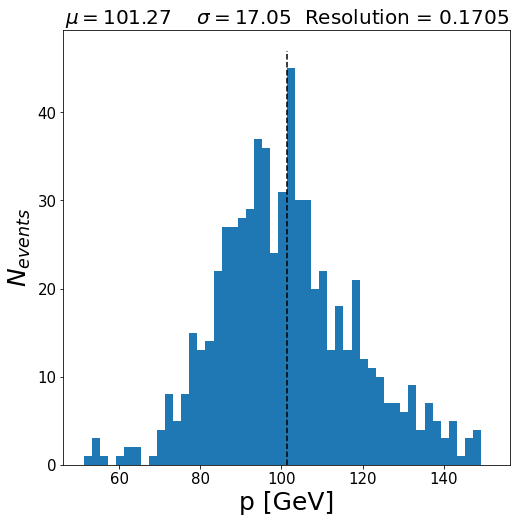

In [20]:
#Set z values
zPosDC1 = np.array([-6.25, -5.75, -5.25, -4.75, -4.25])
zPosDC2 = np.array([2.25, 2.75, 3.25, 3.75, 4.25])

#Set x values to the good units
dc1_xpos_metres=dc1_xpos/1000
dc2_xpos_metres=dc2_xpos/1000

p_values = []
for event in range(dc1_xpos_metres.shape[0]):
    p = compute_p(event,B_TRUE,2) 
    if p > P_TRUE-50 and p < P_TRUE+50 : 
        p_values.append(p)

m, s = stats.norm.fit(p_values) # get mean and standard deviation 

resol = s/P_TRUE

fig = plt.figure(figsize=(8,8))
#plt.hist(p_values,bins=50,range=(m-50,m+50),density=False)
y, x, _ = plt.hist(p_values,bins=50,range=(m-50,m+50),density=False)

plt.vlines(m,0,y.max()+2,linestyles='dashed')
plt.xlabel('p [GeV]',fontsize=25)
plt.ylabel('$N_{events}$',fontsize=25)
plt.xticks(fontsize=15) 
plt.yticks(fontsize=15)
plt.title('$\mu=$'+str(round(m,2)) + '\t' + '$\sigma=$'+str(round(s,2)) + '\t' + 'Resolution = ' + str(round(resol,4)) ,fontsize=20 );


print("mu = ",m)
print("sigma = ",s)

In [148]:
print(np.sqrt(np.var(p_values)))

12.098842918697102


In [1]:
#Imports
from ROOT import TFile
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize , stats
import sys

Welcome to JupyROOT 6.22/06


In [3]:
path="/home/aa/EPPT/run/"

case = "case1_positrons"

In [4]:
#Load file and tree 
load_file = TFile(path+"B5_"+case+".root", "READ")
tree = load_file.Get('B5')

In [5]:
def ECcorrection(E):
        epsilon = 0.61 / (54 + 1.24)
        depth = 0.3 / 1.86
        tmax = np.log(E/epsilon) - 0.5
        t95 = tmax + 0.08*54 + 9.6
        epsilon_corr = (t95/tmax)*epsilon
        return epsilon_corr * ( 1 - np.exp(t95) ) / ( 1 - np.exp(depth) )

In [30]:
ECEnergy = []
ECEnergyCorr = []
Corr = []

for entry in range(0, tree.GetEntries()):
    tree.GetEntry(entry)
    if (np.array( getattr(tree, 'ECEnergy')) /1000 > 0): #Just to be sure there isn't any negative values
        ECcorr = ECcorrection(np.array( getattr(tree, 'ECEnergy')) /1000) /10000
        ECEnergy.append(( np.array( getattr(tree, 'ECEnergy')) /1000 ))
        Corr.append(ECcorr)
        ECEnergyCorr.append((( np.array( getattr(tree, 'ECEnergy')) /1000 ) + ECcorr )/1000)

In [31]:
ECEnergy[:10]

[85.08904051169173,
 91.94856879135925,
 93.36523002810883,
 74.25024180160631,
 88.7457244511578,
 87.23242283342857,
 94.26784659413902,
 81.64111353482389,
 89.94444455775657,
 89.1827801442268]

In [32]:
ECEnergyCorr[:10]

[171.74976513977913,
 185.0656875567845,
 187.81206988015828,
 150.64323205422676,
 178.85198494108525,
 175.91382664454795,
 189.5612781627966,
 165.04476889572794,
 181.17832455582487,
 179.70027861017644]

In [26]:
Corr[:10]

[86660.7246280874,
 93117.11876542527,
 94446.83985204947,
 76392.99025262047,
 90106.26048992744,
 88681.4038111194,
 95293.43156865759,
 83403.65536090407,
 91233.87999806833,
 90517.49846594965]